# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **Semantic-Segmentation (Based on 12/9 Lecture)**
> ### 20181202 김수미

Try to make a good semantic segmentation network using Pascal VOC 2012 dataset.
1. Submit your jupyter notebook. It must contain some detailed explanation of what you have done.
2. Each of you will have time to present your effort.

> ### **0. Import Libraries and Define Function/Class**

In [ ]:
pip install d2l

In [ ]:
pip install matplotlib==3.1.3

In [ ]:
%matplotlib inline
import os
import gc
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from torch import nn
from d2l.torch import *
from d2l import torch as d2l
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [ ]:
def loss(inputs, targets):
  return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

def predict(img):
  X = test_iter.dataset.normalize_image(img).unsqueeze(0)
  pred = net(X.to(devices[0])).argmax(dim=1)
  return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
  colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
  X = pred.long()
  return colormap[X, :]

In [ ]:
# New Data Augmentation
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    normalize])
test_augs = torchvision.transforms.Compose([normalize])

In [ ]:
# Define 'my_load_data_voc' to apply new data augmentation
def my_load_data_voc(batch_size, crop_size):
  voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
  num_workers = d2l.get_dataloader_workers()
  train_iter = torch.utils.data.DataLoader(myVOCSegDataset(True, crop_size, voc_dir, train_augs), batch_size, shuffle=True,
                                          drop_last=True, num_workers=num_workers)
  test_iter  = torch.utils.data.DataLoader(myVOCSegDataset(False, crop_size, voc_dir, test_augs), batch_size,
                                          drop_last=True, num_workers=num_workers)
  return train_iter, test_iter

In [ ]:
# Define 'myVOCSegDataset' to apply new data augmentation
class myVOCSegDataset(torch.utils.data.Dataset):
  def __init__(self, is_train, crop_size, voc_dir, my_augs):
    self.transform = my_augs
    self.crop_size = crop_size
    features, labels = read_voc_images(voc_dir, is_train=is_train)
    self.features = [self.normalize_image(feature) for feature in self.filter(features)]
    self.labels = self.filter(labels)
    self.colormap2label = voc_colormap2label()
    print('read ' + str(len(self.features)) + ' examples')

  def normalize_image(self, img):
    return self.transform(img.float() / 255)

  def filter(self, imgs):
    return [img for img in imgs if (
        img.shape[1] >= self.crop_size[0] and
        img.shape[2] >= self.crop_size[1])]

  def __getitem__(self, idx):
    feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
    return (feature, voc_label_indices(label, self.colormap2label))

  def __len__(self):
    return len(self.features)

> ### **1. First Trial : Efficientnet_b6 Net**
- batch_size : 8 / learning_rate : 0.02 / num_epoch : 20
- loss 0.145 / train acc 0.947 / test acc 0.888

In [ ]:
# Load Dataset(Pascal VOC2012)
batch_size, crop_size = 8, (320,480)
train_iter,test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [ ]:
# Efficientnet_b6 Network
pretrained_net = torchvision.models.efficientnet_b6(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])

num_classes = 21
net.add_module('final_0', nn.Conv2d(2304, num_classes, kernel_size=1))
net.add_module('UpSample', nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False))
net.add_module('final_1', nn.Sequential(nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)))

# Define Parameters / lr(0.02), num_epochs(20)
num_epochs, lr, wd, devices = 20, 0.02, 1e-3, d2l.try_all_gpus()

loss 0.145, train acc 0.947, test acc 0.888
3.4 examples/sec on [device(type='cuda', index=0)]


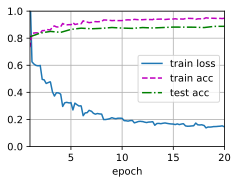

In [ ]:
# Train the model
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

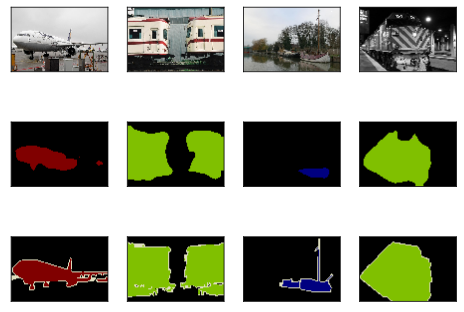

In [ ]:
# Training Result : loss 0.145, train acc 0.947, test acc 0.888
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []

for i in range(n):
  crop_rect = (0, 0, 320, 480)
  X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
  pred = label2image(predict(X))
  imgs += [
    X.permute(1, 2, 0),
    pred.cpu(),
    torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1, 2, 0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

> ### **2. Second Trial : Resnet18 (Edit Parameters)**
- batch_size : 8 / learning_rate : 0.003 / num_epoch : 25
- loss 0.150 / train acc 0.945 / test acc 0.864

loss 0.150, train acc 0.945, test acc 0.864
17.3 examples/sec on [device(type='cuda', index=0)]


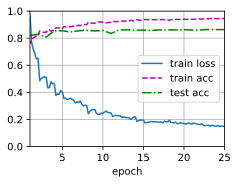

In [ ]:
# Define another net : resnet18
pretrained_net = torchvision.models.resnet18(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])
num_classes = 21
net.add_module('final_0', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('UpSample', nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False))
net.add_module('final_1', nn.Sequential(nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)))

# Define parameters / lr(0.003), num_epochs(25)
num_epochs, lr, wd, devices = 25, 0.003, 1e-3, d2l.try_all_gpus()

# Train the model
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

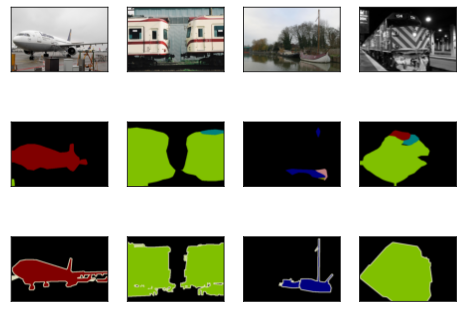

In [ ]:
# Training Result : loss 0.150, train acc 0.945, test acc 0.864
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []

for i in range(n):
  crop_rect = (0, 0, 320, 480)
  X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
  pred = label2image(predict(X))
  imgs += [
    X.permute(1, 2, 0),
    pred.cpu(),
    torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1, 2, 0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

> ### **3. Third Trial : Resnet18 with data Augmentation**
- batch_size : 8 / learning_rate : 0.003 / num_epoch : 25
- loss 0.191, train acc 0.931, test acc 0.846

In [ ]:
# Load data with augmentation
batch_size, crop_size = 8, (320,480)
train_iter,test_iter = my_load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.191, train acc 0.931, test acc 0.846
16.6 examples/sec on [device(type='cuda', index=0)]


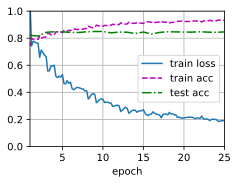

In [ ]:
# Resnet18 with data Augmentation
pretrained_net = torchvision.models.resnet18(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])

num_classes = 21
net.add_module('final_0', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('UpSample', nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False))
net.add_module('final_1', nn.Sequential(nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)))

# Define parameters / lr(0.003), num_epochs(25)
num_epochs, lr, wd, devices = 25, 0.003, 1e-3, d2l.try_all_gpus()

# Train the model
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

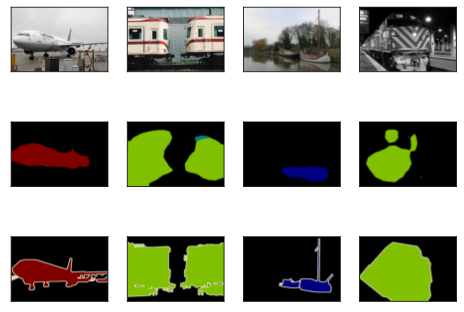

In [ ]:
# Training Result : 
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []

for i in range(n):
  crop_rect = (0, 0, 320, 480)
  X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
  pred = label2image(predict(X))
  imgs += [
    X.permute(1, 2, 0),
    pred.cpu(),
    torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1, 2, 0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

> ### **4. Fourth Trial : Efficientnet_b6 Net with data Augmentation**
- batch_size : 8 / learning_rate : 0.02 / num_epoch : 20
- loss 0.227, train acc 0.922, test acc 0.848

loss 0.227, train acc 0.922, test acc 0.848
4.5 examples/sec on [device(type='cuda', index=0)]


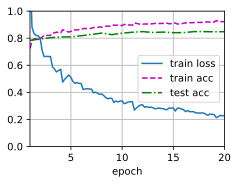

In [ ]:
# Efficientnet_b6 Network with data Augmentation
pretrained_net = torchvision.models.efficientnet_b6(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])

num_classes = 21
net.add_module('final_0', nn.Conv2d(2304, num_classes, kernel_size=1))
net.add_module('UpSample', nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False))
net.add_module('final_1', nn.Sequential(nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)))

# Define Parameters / lr(0.02), num_epochs(20)
num_epochs, lr, wd, devices = 20, 0.01, 1e-3, d2l.try_all_gpus()

# Train the model
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

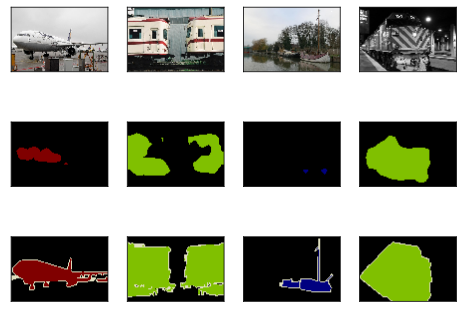

In [ ]:
# Training Result : 
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []

for i in range(n):
  crop_rect = (0, 0, 320, 480)
  X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
  pred = label2image(predict(X))
  imgs += [
    X.permute(1, 2, 0),
    pred.cpu(),
    torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1, 2, 0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

> ### **5. Experiment Result**

> **1) Efficientnet_b6 Net**
- Parameters = batch_size : 8 / learning_rate : 0.01 / num_epoch : 20
- loss 0.145, train acc 0.947, test acc 0.888

> <img src="https://drive.google.com/uc?export=view&id=18jkLi1AAjRthfCB_70QJSXHa7RSG3tPr" align=”left” width="70%">

> **2) Resnet18 with Different Parameters**
- Parameters = batch_size : 8 / learning_rate : 0.003 / num_epoch : 25
- Result = loss 0.150 / train acc 0.945 / test acc 0.864

> <img src="https://drive.google.com/uc?export=view&id=1K__BLcYcZ33Ab2FV-Sg-LATuM2KqDzzP" align=”left” width="70%">

> **3) Resnet18 with Data Augmentation**
- Parameters = batch_size : 8 / learning_rate : 0.003 / num_epoch : 25
- Augmentation = RandomHorizontalFlip
- Result = loss 0.191, train acc 0.931, test acc 0.846

> <img src="https://drive.google.com/uc?export=view&id=16pGqWalOQtMuJYw1LIFuaXW9vaRN_3rQ" align=”left” width="70%">

> **4) Efficientnet_b6 Net with Data Augmentation**
- Parameters = batch_size : 8 / learning_rate : 0.01 / num_epoch : 20
- Augmentation = RandomRotation(-5,5), RandomHorizontalFlip
- Result = loss 0.227, train acc 0.922, test acc 0.848

> <img src="https://drive.google.com/uc?export=view&id=18WjzDfsh75jzPHfG_92dnjktgDCW9Gb5" align=”left” width="70%">